<a href="https://colab.research.google.com/github/Ghazalehz/Wifi-Positioning-System/blob/master/Wifi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Description


Many real world applications need to know the localization of a user in the world to provide their services. So, automatic user localization has been a hot research topic in the last years.		                      
The goal of the project is to build an machine learning model  which will be able to predict the location of an user inside the university Universitat Jaume, Spain. For that, the model will use RSSI signal strength received by mobile handsets of the users in 3 buildings. 	                                                 

**Total number of attributes** : 529 						

1st 520 attributes are RSSI signal intensity. Rests are Longitude, Latitude, Floor, 
Building ID, Space ID etc.             

This piece of code (1st module) will load the data and perform preprocessing.                            

**Version:** 1.0                     

**Author** : Ghazaleh Zamani	                      

**Date**:    12/10/2018 							       

In [0]:
%reload_ext rpy2.ipython


#### Mounting drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####   Loading libraries

In [0]:
%%R


library(plotly)                     
library(ggplot2)                    
library(rworldmap)                  
library(anytime)                    
library(dplyr)                      
library(scales)                     
library(data.table)                 
library(caret)						


In [0]:
%%R
library(anytime)                    


### Loading the Data files

In [0]:
%%R

IndoorLoc = read.csv ('/content/drive/My Drive/Colab Notebooks/trainingData.csv')
IndoorVal = read.csv('/content/drive/My Drive/Colab Notebooks/validationData.csv')

#### Data exploration

In [0]:
%%R
summary(IndoorLoc)
str(IndoorLoc[ncol(IndoorLoc) - 8:ncol(IndoorLoc)])
str(IndoorVal[ncol(IndoorVal) - 8:ncol(IndoorVal)])

#### Plotting the locations 

Training data locations

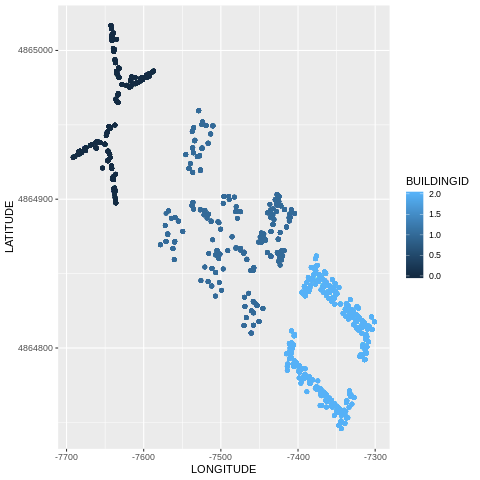

In [58]:
%%R
LocationPlot <- ggplot(IndoorLoc, aes(x=LONGITUDE, y=LATITUDE, 
				      color = BUILDINGID)) + geom_point()
LocationPlot

Validation data locations

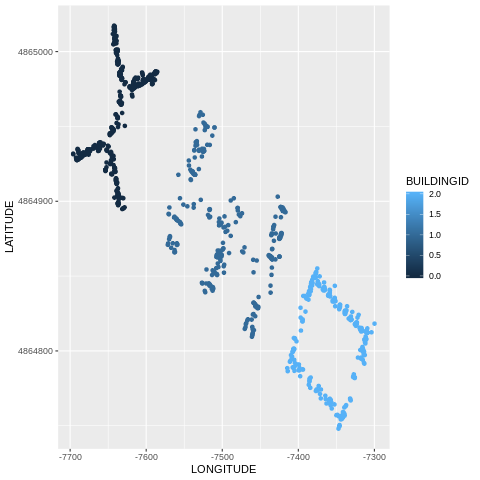

In [60]:
%%R
ValLocPlot <- ggplot(IndoorVal, aes(x=LONGITUDE, y=LATITUDE, 
				    color = BUILDINGID)) + geom_point()
ValLocPlot

Training & Validation data locations in one image

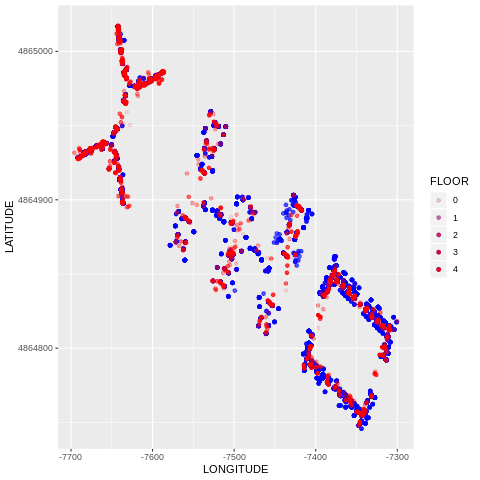

In [61]:
%%R
colVec <- c("blue", "red")
ggplot() +
  geom_point(data = IndoorLoc, mapping = aes(LONGITUDE, LATITUDE, 
					     color = colVec[1], alpha = FLOOR), 
	     color = colVec[1], show.legend = TRUE)+
  geom_point(data = IndoorVal, mapping = aes(LONGITUDE, LATITUDE, 
					     color = colVec[2], alpha = FLOOR), 
	     color = colVec[2], show.legend = TRUE)

#### Histogram of the ranges of RSSI values

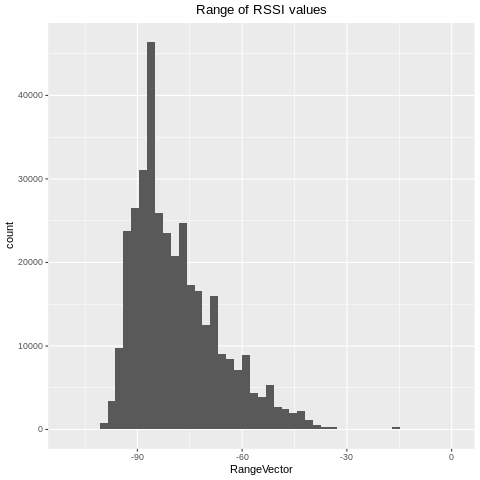

In [62]:
%%R
Ranges <- subset(IndoorLoc, select = WAP001:WAP520)
RangeVector <- c(as.matrix(Ranges))

ggplot() + geom_histogram(aes(x = RangeVector), bins = 50) + 
              ggtitle("Range of RSSI values") + 
                 theme(plot.title = element_text(hjust = 0.5)) + xlim(-110,1)

#### Histogram of WLAN Access Points (WAPs)
It shows the number of WAPs detected by a WiFi scan across the number of database records

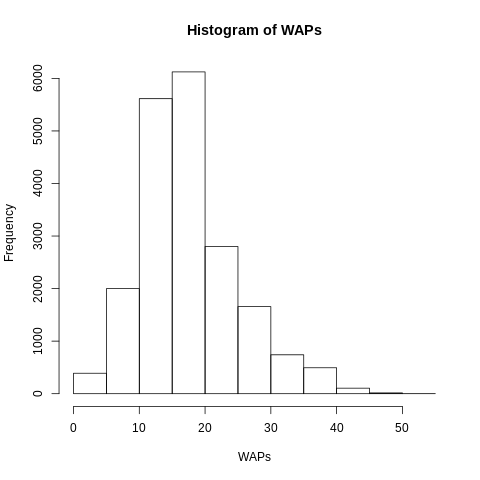

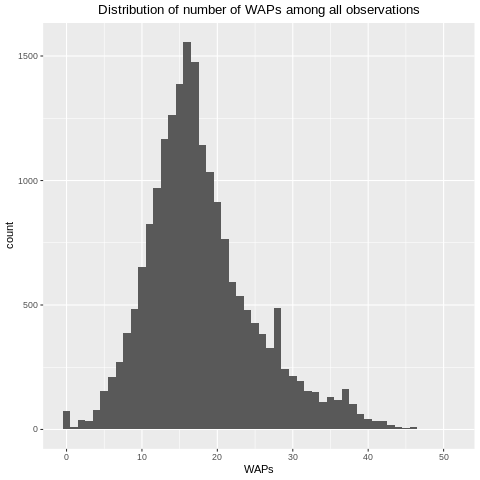

In [65]:
%%R
WAPs <- apply(Ranges, 1, function(x) sum(x!=100))
hist(WAPs)
	      
ggplot() + geom_histogram(aes(x = WAPs), bins = 52) + 
	      ggtitle("Distribution of number of WAPs among all observations") + 
                 theme(plot.title = element_text(hjust = 0.5))


#### Changing the attribute types 

In [0]:
%%R
IndoorLoc$FLOOR <- as.factor(IndoorLoc$FLOOR)
IndoorVal$FLOOR <- as.factor(IndoorVal$FLOOR)
IndoorLoc$BUILDINGID <- as.factor(IndoorLoc$BUILDINGID)
IndoorVal$BUILDINGID <- as.factor(IndoorVal$BUILDINGID)
IndoorLoc$SPACEID <- as.factor(IndoorLoc$SPACEID)
IndoorVal$SPACEID <- as.factor(IndoorVal$SPACEID)
IndoorLoc$RELATIVEPOSITION <- as.factor(IndoorLoc$RELATIVEPOSITION)
IndoorVal$RELATIVEPOSITION <- as.factor(IndoorVal$RELATIVEPOSITION)
IndoorLoc$USERID <- as.factor(IndoorLoc$USERID)
IndoorVal$USERID <- as.factor(IndoorVal$USERID)
IndoorLoc$PHONEID <- as.factor(IndoorLoc$PHONEID)
IndoorVal$PHONEID <- as.factor(IndoorVal$PHONEID)
IndoorLoc$TIMESTAMP <- anytime(IndoorLoc$TIMESTAMP, tz = "GMT")
IndoorVal$TIMESTAMP <- anytime(IndoorVal$TIMESTAMP, tz = "GMT")


###  PREPROCESSING    

The preprocessing has been applied to both training and validation set. 


RSSI signal strength '100' means there is no signal
Therefore RSSI signal values are changed from '100' to '-105' dBm

In [0]:
%%R
IndoorLoc[IndoorLoc==100]<- -105
IndoorVal[IndoorVal==100]<- -105


#### Taking columns that contain only -105 out.

Training DataSet

In [0]:
%%R
noSignal <- (as.data.frame(lapply((apply(IndoorLoc, 2, max)), function(x)
{ifelse (x == -105, TRUE, FALSE)})))

IndoorLoc <- IndoorLoc[,!noSignal]



Validation DataSet

In [0]:
%%R
noSignal <- NULL
noSignal <- (as.data.frame(lapply((apply(IndoorVal, 2, max)), function(x)
{ifelse (x == -105, TRUE, FALSE)})))

IndoorVal <- IndoorVal[,!noSignal]

#### Taking out rows that have no WAP measurements

Training DataSet

In [0]:
%%R
IndoorLoc <- IndoorLoc[apply(IndoorLoc[,1:(ncol(IndoorLoc)-9)], 1, function(x) 
{ifelse(max(x) == -105, FALSE, TRUE)}),]


Validation DataSet

In [0]:
%%R
IndoorVal <- IndoorVal[apply(IndoorVal[,1:(ncol(IndoorVal)-9)], 1, function(x) 
{ifelse(max(x) == -105, FALSE, TRUE)}),]


####  Remove columns with Near Zero variance


Number of columns with near zero variance 

deleteCols- Columns to be deleted

In [0]:
%%R
deleteCols <- nearZeroVar(IndoorLoc[,1:(ncol(IndoorLoc) - 9)], 
                                        saveMetrics = TRUE, uniqueCut = 0.015)$nzv

IndoorLoc <- IndoorLoc[ , !(names(IndoorLoc) %in% colnames(IndoorLoc[,deleteCols]))]


The number of individual measures inside range [−30dBm - 0dBm] is insignificant 
It cover approx 1% of total RSSI levels recorded in the database

So excluding WAPs with the signal range [−30dBm - 0dBm]


In [0]:
%%R
IndoorLoc <- IndoorLoc%>% mutate( not_wap30_0 = apply(IndoorLoc[,1:(ncol(IndoorLoc)-9)], 1, 
                                                 function(x) !(TRUE %in% (x > -30 & x <= 0))))                           

IndoorLoc <- IndoorLoc[IndoorLoc$not_wap30_0,]
  
IndoorLoc$not_wap30_0 <- NULL

#### Removing duplicate rows in both Training and Validation sets

In [0]:
%%R
IndoorLoc <- unique(IndoorLoc)
IndoorVal <- unique(IndoorVal) 

Normalizing Training and validation sets so that standard deviation = 0,
It will also prevent any NA values


In [0]:
%%R
IndoorLoc <- IndoorLoc[which(apply(IndoorLoc[, 1:(ncol(IndoorLoc) - 9)], 1, sd) != 0),]

IndoorVal<- IndoorVal[which(apply(IndoorVal[,1:(ncol(IndoorVal) - 9)],1,sd)!=0),]

#### Keeping all features of Validation data set in Training data set

In [0]:
%%R
IndoorLoc <- IndoorLoc[, which(names(IndoorLoc) %in% names(IndoorVal))]


#### Deleting unnecessary columns because 1st case predicting Buildings.

In [0]:
%%R
IndoorLoc$LONGITUDE<- NULL
IndoorLoc$LATITUDE<- NULL
IndoorLoc$FLOOR<- NULL


IndoorVal$LONGITUDE<- NULL
IndoorVal$LATITUDE<- NULL
IndoorVal$FLOOR<- NULL

#### Normalizing trainset and testsets in rows 

In [0]:
%%R
IndoorLoc[,1:(ncol(IndoorLoc) - 6)]<-
           t(apply(IndoorLoc[,1:(ncol(IndoorLoc) - 6)],1, 
           function(x)((x)- min(x))/(max(x)- min(x))))


IndoorVal[,1:(ncol(IndoorVal) - 6)]<-
  t(apply(IndoorVal[,1:(ncol(IndoorVal) - 6)],1, 
          function(x)((x)- min(x))/(max(x)- min(x))))